In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import pickle
import os

import numpy as np
import pandas as pd

import scipy

import mne
from matplotlib import pyplot as plt

import constants
import dataset
import folders
import iter_topography_fork
import analysis_and_plotting_functions as aps

In [2]:
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams.update({'font.size': 10})

In [3]:
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)

100 percent complete

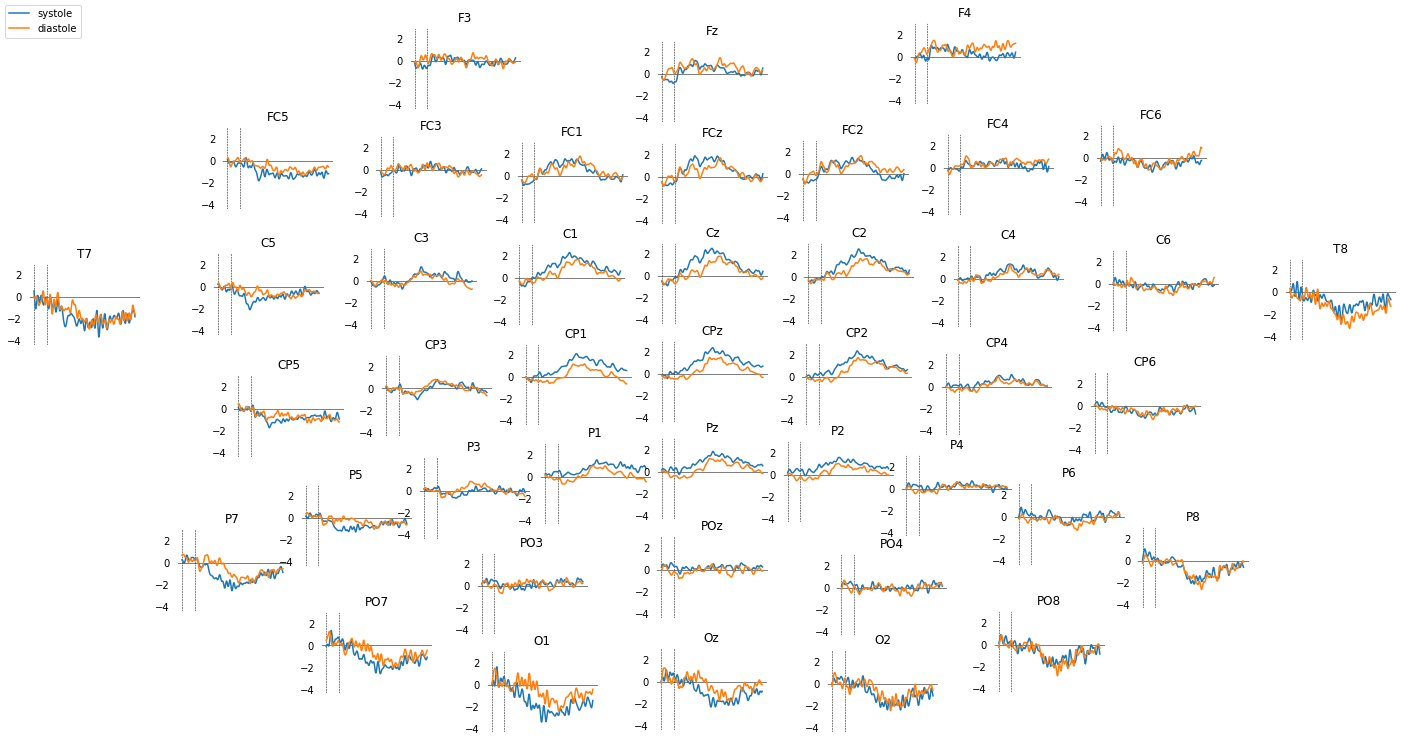

C:\Projects\Work\erp_analysis\analysis_and_plotting_functions.py:326: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  stat_fun=stat_fun


[                                      ]   0.00%  |
No significant clusters found
(2,) (2, 451, 45)


In [36]:
condition_names = ['systole', 'diastole']
blind = 0

subset_systole = ds.markup.loc[
                            (ds.markup['reg'] == 'brl_static6_all8') &
#                             (ds.markup['blind'] == blind) &
                            (ds.markup['ms_after_r']<250)
                            ]

subset_diastole = ds.markup.loc[
                            (ds.markup['reg'] == 'brl_static6_all8') &
#                             (ds.markup['blind'] == blind) &
                            (ds.markup['ms_before_r']<250)
                            ]
d = ds.create_mne_epochs_from_subset(subset_diastole).drop_channels(['Fp1', 'Fp2', 'ecg'])
s = ds.create_mne_epochs_from_subset(subset_systole).drop_channels(['Fp1', 'Fp2', 'ecg'])

p = aps.plot_evoked_response(data={ 'systole': aps.subset(ds, subset_systole)['target'].\
                                               crop(0,0.8).\
                                               set_eeg_reference('average').drop_channels(['Fp1', 'Fp2']),
                                   'diastole': aps.subset(ds, subset_diastole)['target'].\
                                               crop(0,0.8).\
                                               set_eeg_reference('average').drop_channels(['Fp1', 'Fp2'])},
                             title=f'')


X = [s._data.reshape(s._data.shape[0], s._data.shape[2], s._data.shape[1]), 
     d._data.reshape(d._data.shape[0], d._data.shape[2], d._data.shape[1])]

info = d.info
times = s.times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=100, tail=0, n_jobs=-1, plot_range=False)

C:\Projects\Work\erp_analysis\analysis_and_plotting_functions.py:326: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  stat_fun=stat_fun


[                                      ]   0.00%  |
[0.01]
(2, 20, 451, 45) (2, 451, 45)
Mean F-score for cluster 18.069848114017073
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


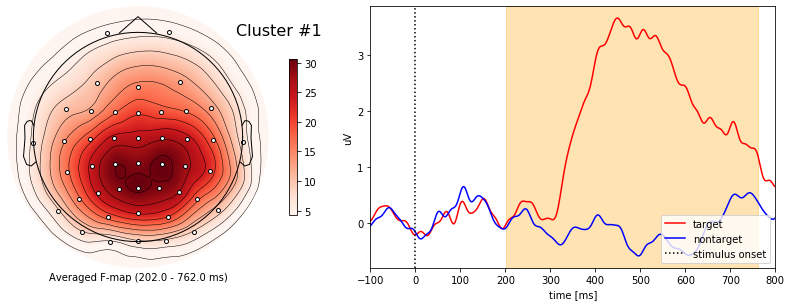

In [13]:
target = []
nontarget = []
condition_names = ['target', 'nontarget']

for user in set(ds.markup['user']):
    subset_user= ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    ep=aps.subset(ds, subset_user)

    target.append(ep['target'])
    nontarget.append(ep['nontarget'])

X = [np.array([a.data.T for a in target]), 
     np.array([a.data.T for a in nontarget])]
info = nontarget[0].info
times = nontarget[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=100, tail=0, n_jobs=-1, plot_range=False)

In [ ]:
# target blind vs sighted - letter averaged
blind = []
sighted = []
condition_names = ['blind', 'sighted']

for user in set(ds.markup['user']):
    print (user)
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        blind.append(aps.subset(ds, subset_blind)['delta'].crop(tmax=0.8, tmin=0))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=100, tail=1, n_jobs=-1, cutoff_pval=0.05, plot_range=[0.25, 0.75],
                    stat_fun = None)                             
#                     stat_fun = lambda *args: scipy.stats.kruskal(*args)[0])